In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.text import Tokenizer

# Setting up Captions

In [ ]:
import nltk
#removing stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing import sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/IITMK/sem3/CV term paper/datasets/Tamil_troll_memes/train_captions.csv',sep=',')
train.head(15)

,Unnamed: 0,imagename,captions
0,0,Not_troll_0.jpg,Ada pikkalipayalugala
1,1,Not_troll_1.jpg,Etho sambavam nadandhirukkum pola
2,2,Not_troll_10.jpg,Vunnayellam frienda vechirukken paaru
3,3,Not_troll_100.jpg,Idho! Ivan dhaan naan nasama ponadhukku kaaranam
4,4,Not_troll_1000.jpg,Ennada lusu thanama pesikittu irukka lusu payale
5,5,Not_troll_1001.jpg,Vuhvuhvuhvuhvuh........
6,6,Not_troll_1002.jpg,Yenna ore pattasu sathama kekkudhu..\nOhhoo.. ...
7,7,Not_troll_1003.jpg,Inimel ipidi post pottal vailaye vettuven
8,8,Not_troll_1004.jpg,Ivaingakittarundhu yepidi thapikka porenanu th...
9,9,Not_troll_1005.jpg,(no caption)


In [ ]:
#function for stop works removing
stop = stopwords.words('english')
def remove_sw(txt):
    no_sw =" ".join([a for a in txt.split() if a not in stop])
    return no_sw

#funciton for preprocessing
def preprocessing_txt( captions):
  captions = captions.apply(lambda x: remove_sw(x))
  captions = captions.str.lower() 
  captions = captions .str.strip()       #remove white spaces
  captions = captions .str.replace(r'\d+','')   #remove numbers  
  captions = captions .apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))  #removing emoji
  captions = captions .str.replace('[^\w\s]','')  
  
  #words in each line
  totalwords =  captions.str.count(' ') + 1
  tok1 = Tokenizer(char_level=False, filters ='!"$%&@()*+,-./:;”“<=>?[\\]^_`{|}~\t\n', lower = True)
  tok1.fit_on_texts( captions)
  words=len(tok1.word_counts)
  encode=tok1.texts_to_sequences(captions)

  ##  Padding encoded sequence of words
  max_length=30
  padd = sequence.pad_sequences(encode, maxlen=max_length, padding='post') 
  return  captions, totalwords, words, encode, padd 

# setting labels
def labeling(train):
  train['Label'] = train['imagename'].str.replace('\d+', '')
  train['Label'] = train['Label'].str.replace('_.jpg', '')
  train['Label'] = train['Label'].str.replace('_.png', '')
  return train['Label']

In [ ]:
train['captions'], train['totalwords'], words, encode, padd = preprocessing_txt(train['captions'])
train['Label'] = labeling(train)

In [ ]:
train

,Unnamed: 0,imagename,captions,totalwords,Label
0,0,Not_troll_0.jpg,ada pikkalipayalugala,2,Not_troll
1,1,Not_troll_1.jpg,etho sambavam nadandhirukkum pola,4,Not_troll
2,2,Not_troll_10.jpg,vunnayellam frienda vechirukken paaru,4,Not_troll
3,3,Not_troll_100.jpg,idho ivan dhaan naan nasama ponadhukku kaaranam,7,Not_troll
4,4,Not_troll_1000.jpg,ennada lusu thanama pesikittu irukka lusu payale,7,Not_troll
...,...,...,...,...,...
2295,2345,troll_439.jpg,amma yaaro orutharu pattu paaduraaruma amma na...,14,troll
2296,2346,troll_44.jpg,phone n twitter hacked please respond random m...,18,troll
2297,2347,troll_440.jpg,respected deat narendramodi ji hearty corigrat...,11,troll
2298,2348,troll_441.jpg,engu irutha nan mnnil piranthidum bothu vera e...,14,troll


In [ ]:
# image_path = train['imagename']
# label = train['Label']

### Encoding Labels

In [ ]:
#counting labels      
train['Label'].value_counts()

troll        1282
Not_troll    1018
Name: Label, dtype: int64

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()

# function for encoding labels
def encodelabels(labels):  
  labels =  Encoder.fit_transform(labels)                                                      
  return labels


In [ ]:
train['Label'] = encodelabels(train['Label'])

In [ ]:
#counting labels      
train['Label'].value_counts()

1    1282
0    1018
Name: Label, dtype: int64

In [ ]:
print(train['Label'])

0       0
1       0
2       0
3       0
4       0
       ..
2295    1
2296    1
2297    1
2298    1
2299    1
Name: Label, Length: 2300, dtype: int64


# Setting up Images

In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224
# img_folder=r'/content/drive/MyDrive/IITMK/sem3/CV term paper/datasets/Tamil_troll_memes/training_img'

def create_dataset(img_folder):
   
    img_data_array=[]
    # class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path)
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = image.astype('float32')
            image /= 255 
            image =np.array(image)
            img_data_array.append(image)
            # class_name.append(dir1)
    return np.array(img_data_array)

In [ ]:
# training input in array
train_image_array = create_dataset(r'/content/drive/MyDrive/IITMK/sem3/CV term paper/datasets/Tamil_troll_memes/training_img')
train_image_array.shape

(2300, 224, 224, 3)

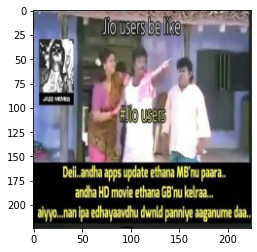

In [ ]:
# Printing single image
import matplotlib.pyplot as plt
plt.imshow(train_image_array[3])

# Test set

In [ ]:
test=pd.read_csv('/content/drive/MyDrive/IITMK/sem3/CV term paper/datasets/Tamil_troll_memes/test_captions.csv',sep=',')
test.pop('Unnamed: 0')
test['captions'], test['totalwords'], words1, encode1, padd1 = preprocessing_txt(test['captions'])
test

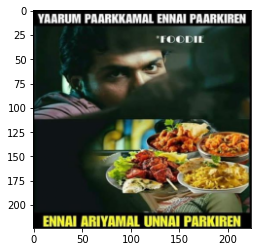

In [ ]:
# extract the image array 
test_image_data =create_dataset(r'/content/drive/MyDrive/IITMK/sem3/CV term paper/datasets/Tamil_troll_memes/test_img')
# Printing single image
import matplotlib.pyplot as plt
plt.imshow(test_image_data[10])

In [ ]:
# test_image_data = np.asarray(test_img_data)
test_image_data.shape

(667, 224, 224, 3)

# Model creation


In [ ]:
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D,LSTM,Bidirectional,GlobalAveragePooling1D,Dropout, Activation, Flatten, Embedding,Input
from keras.layers.merge import concatenate

In [ ]:
#image model
# channel 0 
inputs = Input(shape=(224, 224, 3))
conv = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)
pool = MaxPooling2D(pool_size=(5,5))(conv)
conv2=Conv2D(64,(3,3),activation='relu')(pool)
pool2=MaxPooling2D(pool_size=(2,2),padding='same')(conv2)
flat = Flatten()(pool2)

In [ ]:
max_length = 30
Embedding_Layer=Embedding(input_dim = words + 1, output_dim = 300,input_length=max_length)

#text model
# channel 1
inputs1 = Input(shape=max_length)
embedding1 = Embedding_Layer(inputs1)
#conv1 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding1)
#drop1 = Dropout(0.5)(conv1)
#pool1 = MaxPooling1D(pool_size=2)(drop1)
lstm=Bidirectional(LSTM(128))(embedding1)
flat1 = Flatten()(lstm)

In [ ]:
#concatinate
merged = concatenate([flat1, flat])
dense1 = Dense(256, activation='relu')(merged)
dense2 = Dense(128, activation='relu')(dense1)
dropout1 = Dropout(0.1)(dense2)
dense3 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense3)
outputs = Dense(1, activation='softmax')(dropout2)
model = Model(inputs=[inputs1, inputs], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                              

In [ ]:
model.compile(optimizer = 'Adam', loss ="binary_crossentropy", metrics = ['accuracy'])

In [ ]:
model.fit([padd,train_image_array],train['Label'], epochs = 10, verbose = 1)

Epoch 1/10
72/72 [==============================] - 19s 68ms/step - loss: 0.5821 - accuracy: 0.5574
Epoch 2/10
72/72 [==============================] - 5s 63ms/step - loss: 0.1806 - accuracy: 0.5574
Epoch 3/10
72/72 [==============================] - 5s 64ms/step - loss: 0.0568 - accuracy: 0.5574
Epoch 4/10
72/72 [==============================] - 5s 64ms/step - loss: 0.0346 - accuracy: 0.5574
Epoch 5/10
72/72 [==============================] - 5s 64ms/step - loss: 0.0224 - accuracy: 0.5574
Epoch 6/10
72/72 [==============================] - 5s 64ms/step - loss: 0.0140 - accuracy: 0.5574
Epoch 7/10
72/72 [==============================] - 5s 64ms/step - loss: 0.0159 - accuracy: 0.5574
Epoch 8/10
72/72 [==============================] - 5s 63ms/step - loss: 0.0392 - accuracy: 0.5574
Epoch 9/10
72/72 [==============================] - 5s 63ms/step - loss: 0.0129 - accuracy: 0.5574
Epoch 10/10
72/72 [==============================] - 5s 63ms/step - loss: 0.0105 - accuracy: 0.5574


In [ ]:
dev_predictions = model.predict([padd1,test_image_data])
# Finding out of two output neurons which one has highest probability
# It will return us the predicted class
# It will convert probability into final class 1 and 0
dev_predictions1 = np.zeros_like(dev_predictions)
dev_predictions1[np.arange(len(dev_predictions)), dev_predictions.argmax(1)] = 1

In [ ]:
dev_predictions1 = dev_predictions1.astype(int)

In [ ]:
test_label = pd.read_csv('/content/drive/MyDrive/IITMK/sem3/CV term paper/datasets/Tamil_troll_memes/gold_labels_for_test.csv')
test_label

,Unnamed: 0,ref_caption,label
0,0,test_img_0.jpg,troll
1,1,test_img_1.jpg,troll
2,2,test_img_2.jpg,troll
3,3,test_img_3.jpg,troll
4,4,test_img_4.jpg,troll
...,...,...,...
662,662,test_img_662.jpg,troll
663,663,test_img_663.jpg,troll
664,664,test_img_664.jpg,troll
665,665,test_img_665.jpg,not_troll


In [ ]:
# val_labelEncode=labelEncode.transform(test_label['label'])
# val_label=to_categorical(np.asarray(val_labelEncode))
# val_label[0]

val_label = encodelabels(test_label['label'])

In [ ]:
# rounded_labels=np.argmax(val_label, axis=0)

In [ ]:
val_label

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,

In [ ]:
#evaluating the model with train and test
model.evaluate((padd,train_image_array),train['Label']),model.evaluate((padd1,test_image_data),val_label)

21/21 [==============================] - 2s 29ms/step - loss: 7.4621 - accuracy: 0.5922


([0.005425882991403341, 0.5573912858963013],
 [7.462083339691162, 0.5922039151191711])

In [ ]:
#Accuracy CNN
from sklearn.metrics import classification_report
print(classification_report(val_label,dev_predictions1, zero_division=1))


              precision    recall  f1-score   support

           0       1.00      0.00      0.00       272
           1       0.59      1.00      0.74       395

    accuracy                           0.59       667
   macro avg       0.80      0.50      0.37       667
weighted avg       0.76      0.59      0.44       667



In [ ]:
y_pred = np.unique(dev_predictions)

In [ ]:
# acc = model.model['accuracy']